<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [59]:
# Imports
import re
import string
from collections import Counter
import pandas as pd
import numpy as np

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity

# Plotting Libraries
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# HTML parsing
from bs4 import BeautifulSoup
import requests

# Load spaCy medium model
nlp = spacy.load('en_core_web_md')

# Show a progress bar
from tqdm import tqdm
tqdm.pandas()

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
# Read in the data
job = pd.read_csv('./data/job_listings.csv', index_col=0)  # index_col=0 removes the extra index column
job

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist
...,...,...
421,"b""<b>About Us:</b><br/>\nWant to be part of a ...",Senior Data Science Engineer
422,"b'<div class=""jobsearch-JobMetadataHeader icl-...",2019 PhD Data Scientist Internship - Forecasti...
423,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist - Insurance
424,"b""<p></p><div><p>SENIOR DATA SCIENTIST</p><p>\...",Senior Data Scientist


In [3]:
# Remove the b and ' from the beginning of the values in description
job['description'] = job['description'].str.lstrip('b"').str.lstrip("'")
job.head()

,description,title
0,<div><div>Job Requirements:</div><ul><li><p>\n...,Data scientist
1,<div>Job Description<br/>\n<br/>\n<p>As a Data...,Data Scientist I
2,<div><p>As a Data Scientist you will be workin...,Data Scientist - Entry Level
3,"<div class=""jobsearch-JobMetadataHeader icl-u-...",Data Scientist
4,<ul><li>Location: USA \xe2\x80\x93 multiple lo...,Data Scientist


In [4]:
# Create a new empty column
job['parsed'] = None

# Iterate through the data to remove html tags and characters not needed
for i in range(len(job)):
    soup = BeautifulSoup(job['description'][i], 'html.parser')  # Removes html tags
    
    data = []  # Create an empty list to hold cleaned data

    # Iterate through each string to clean the text
    for string in soup.strings:
        d = string.replace('\\n', ' ').lower()  # Remove new line characters and lowercase text
        d2 = d.replace(',', '')  # Remove commas
        d3 = re.sub(r'[^a-z A-Z 0-9]\s*', '', d2)  # Remove anything else that is not alphanumeric
        data.append(d3)  # Add the cleaned string to the data list
        
    job['parsed'][i] = data  # Add cleaned text to new column
    
# Make sure all values are one long string per document
job['parsed'] = job['parsed'].apply(lambda x: ' '.join(x))

In [5]:
# Verify the parser worked right
job.head()

,description,title,parsed
0,<div><div>Job Requirements:</div><ul><li><p>\n...,Data scientist,job requirements conceptual understanding in ...
1,<div>Job Description<br/>\n<br/>\n<p>As a Data...,Data Scientist I,job description as a data scientist 1 you ...
2,<div><p>As a Data Scientist you will be workin...,Data Scientist - Entry Level,as a data scientist you will be working on con...
3,"<div class=""jobsearch-JobMetadataHeader icl-u-...",Data Scientist,4969 6756 a month contract under the general s...
4,<ul><li>Location: USA \xe2\x80\x93 multiple lo...,Data Scientist,locationusa xe2x80x93 multiple locations 2ye...


In [6]:
job.tail()

,description,title,parsed
421,<b>About Us:</b><br/>\nWant to be part of a fa...,Senior Data Science Engineer,about us want to be part of a fantastic and f...
422,"<div class=""jobsearch-JobMetadataHeader icl-u-...",2019 PhD Data Scientist Internship - Forecasti...,internship at uber we ignite opportunity by se...
423,"<div class=""jobsearch-JobMetadataHeader icl-u-...",Data Scientist - Insurance,200000 350000 a year a million people a year d...
424,<p></p><div><p>SENIOR DATA SCIENTIST</p><p>\nJ...,Senior Data Scientist,senior data scientist job description abou...
425,<div></div><div><div><div><div><p>Cerner Intel...,Data Scientist,cerner intelligence is a new innovative organi...


## 2) Use Spacy to tokenize the listings 

In [7]:
# Instantiate the spaCy tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Need an empty list to hold all the tokens
tokens = []

# Iterate through each document to tokenize the words
for doc in tokenizer.pipe(job['parsed'], batch_size=100):
    
    doc_tokens = []  # Empty list to hold tokens for each document
    
    # Iterate through each document
    for token in doc:
        # Remove stop words, punctuation, and empty whitespace
        if(token.is_stop == False) & (token.is_punct == False) & (token.is_space == False):
            doc_tokens.append(token.text)  # Add tokens for each document
            
    tokens.append(doc_tokens)  # Add document tokens for all documents in the dataset
    
# Create a new column for the tokens
job['tokens'] = tokens

# Check my work
job.head()

,description,title,parsed,tokens
0,<div><div>Job Requirements:</div><ul><li><p>\n...,Data scientist,job requirements conceptual understanding in ...,"[job, requirements, conceptual, understanding,..."
1,<div>Job Description<br/>\n<br/>\n<p>As a Data...,Data Scientist I,job description as a data scientist 1 you ...,"[job, description, data, scientist, 1, help, b..."
2,<div><p>As a Data Scientist you will be workin...,Data Scientist - Entry Level,as a data scientist you will be working on con...,"[data, scientist, working, consulting, busines..."
3,"<div class=""jobsearch-JobMetadataHeader icl-u-...",Data Scientist,4969 6756 a month contract under the general s...,"[4969, 6756, month, contract, general, supervi..."
4,<ul><li>Location: USA \xe2\x80\x93 multiple lo...,Data Scientist,locationusa xe2x80x93 multiple locations 2ye...,"[locationusa, xe2x80x93, multiple, locations, ..."


In [8]:
# Show more data in the columns
pd.set_option('display.max_colwidth', 150)

In [9]:
# Compare the tokens and description for first 10
job[['tokens', 'description']].sample(10)

,tokens,description
292,"[discovera, rewarding, way, work, discover, financial, services, youxe2x80x99ll, find, company, industryxe2x80x99s, smartest, reliable, profession...","<div><p>Discover. A more rewarding way to work.</p>\n<p>\nAt Discover Financial Services, you\xe2\x80\x99ll find yourself in the company of some o..."
173,"[hiring, remote, data, scientist, strong, machine, learning, background, 3years, experience, requirements, degree, required, deep, understanding, ...","<div><p>We are hiring a remote Data Scientist with strong Machine Learning background and about 3+ years of experience.</p>\n<h3 class=""jobSection..."
74,"[62844, 100908, year, summary, oregon, state, lottery, modernizing, technology, processes, gaming, offers, better, meet, needs, digital, worldwere...","<div class=""jobsearch-JobMetadataHeader icl-u-xs-mb--md""><div class=""jobsearch-JobMetadataHeader-item ""><span class=""icl-u-xs-mr--xs"">$62,844 - $1..."
170,"[database, engineersecret, work, youxe2x80x99ll, team, analytics, cognitive, age, disruption, organizations, need, navigate, future, confidence, e...",<div><div>Database Engineer- Secret</div><br/>\n<div></div>\n<div><b>\nWork you\xe2\x80\x99ll do</b></div><br/>\n<div></div>\n<div><b>\nThe team</...
217,"[senior, business, intelligence, data, engineer, rocky, hill, ct, job, description, overview, axians, redtoo, recently, brought, 30, years, experi...","<div><div><div><div><h1 class=""jobSectionHeader""><b>Senior Business Intelligence Data Engineer</b></h1>\nRocky Hill, CT<br/>\n<br/>\n<br/>\n<br/>\..."
403,"[interested, working, humancentered, technology, company, prides, modern, tools, technologieswant, surrounded, intensely, curious, innovative, thi...",About Us\n<br/>Interested in working for a human-centered technology company that prides itself on using modern tools and technologies? Want to be...
422,"[internship, uber, ignite, opportunity, setting, world, motionwe, big, problems, help, drivers, riders, delivery, partners, eaters, moving, 600, c...","<div class=""jobsearch-JobMetadataHeader icl-u-xs-mb--md""><div class=""jobsearch-JobMetadataHeader-item icl-u-xs-mt--xs"">Internship</div></div><div>..."
412,"[nike, supply, chain, experts, ensure, year, 13, billion, pieces, footwear, apparel, equipment, arrive, right, destination, timethatxe2x80x99s, ea...","<div>Nike Supply Chain experts ensure that every year 1.3 billion pieces of footwear, apparel, and equipment arrive at the right destination on ti..."
335,"[spin, spin, operates, electric, scooters, cities, campuses, nationwide, bringing, sustainable, lastmile, mobility, solutions, diverse, communitie...","<div><div><div><b>About Spin</b></div><div><br/>\n</div><div>\nSpin operates electric scooters in cities and campuses nationwide, bringing sustain..."
377,"[team, responsible, placing, ad, twitter, serveswhile, placing, ads, decide, best, balance, user, experience, advertiser, results, twitter, revenu...","<div><div><div><div><div><div><h3 class=""jobSectionHeader""><b>Who We Are</b></h3>\n<p>The team is responsible for placing each and every ad that T..."


In [10]:
def count(docs):
    '''
    This function takes a list of tokenized documents as input and returns
    a dataframe with frequency counts and rank for each token.
    
    # Arguments
        docs: list, tokenized list of documents
        
    # Returns
        wc: dataframe, 
    '''
    
    word_counts = Counter()  # the total word count per document (aka row)
    appears_in = Counter()  # the total unique words that appear in the document (aka row)

    total_docs = len(docs)  # the total number of documents (aka rows)

    for doc in docs:
        word_counts.update(doc)  # gives the word cound for each document
        appears_in.update(set(doc))  # gives the unique words in a single document

    temp = zip(word_counts.keys(), word_counts.values())  # creates a 2d list of the word and it's count

    wc = pd.DataFrame(temp, columns = ['word', 'count'])  # creates a DataFrame with the word and the number of instances

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()  # ranks the words and returns the sum of each word

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)  # gives the percentage of how often the words appear

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()  # sorts the values by the count

    t2 = zip(appears_in.keys(), appears_in.values())  # creates a 2d list of the words and how often they appear
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])  # turns the above into a DataFrame
    wc = ac.merge(wc, on='word')  # merges the 2 DataFrames together

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)  # gives the percentage of how often it appears in the document

    return wc.sort_values(by='rank')  # sorts the values by the rank column.

In [11]:
# Get word counts for my tokens
wc = count(job['tokens'])
print(wc.shape)
wc.head(15)

(12909, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
49,data,422,4124,1.0,0.031834,0.031834,0.990610
6,experience,403,1798,2.0,0.013879,0.045713,0.946009
92,business,313,1136,3.0,0.008769,0.054482,0.734742
31,work,354,1095,4.0,0.008453,0.062935,0.830986
67,science,332,919,5.0,0.007094,0.070029,0.779343
109,team,332,904,6.0,0.006978,0.077007,0.779343
37,learning,304,882,7.0,0.006808,0.083815,0.713615
337,analytics,245,694,8.0,0.005357,0.089172,0.575117
35,machine,273,675,9.0,0.005210,0.094383,0.640845
279,analysis,291,648,10.0,0.005002,0.099385,0.683099


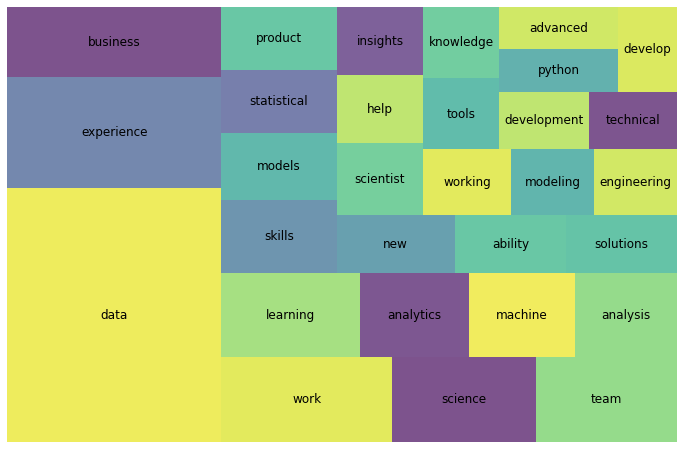

In [15]:
# Look at the top 30 words in a plot:
wc_top30 = wc[wc['rank'] <= 30]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=wc_top30['pct_total'], label=wc_top30['word'], 
              alpha=.70, text_kwargs={'size': 12})
plt.axis('off');

In [16]:
# Get just the stem words
ps = PorterStemmer()  # Instantiate the porter stemmer
STOP_WORDS = nlp.Defaults.stop_words  # Create a stop words list with just the default spaCy stop words
job['stems'] = job['tokens'].progress_apply(lambda x: [ps.stem(word) for word in x if word not in STOP_WORDS])
job.head(1)

100%|███████████████████████████████████████████████████████████████████████████████| 426/426 [00:02<00:00, 178.74it/s]


,description,title,parsed,tokens,stems
0,"<div><div>Job Requirements:</div><ul><li><p>\nConceptual understanding in Machine Learning models like Nai\xc2\xa8ve Bayes, K-Means, SVM, Apriori,...",Data scientist,job requirements conceptual understanding in machine learning models like naixc2xa8ve bayes kmeans svm apriori linearlogistic regression neural r...,"[job, requirements, conceptual, understanding, machine, learning, models, like, naixc2xa8ve, bayes, kmeans, svm, apriori, linearlogistic, regressi...","[job, requir, conceptu, understand, machin, learn, model, like, naixc2xa8v, bay, kmean, svm, apriori, linearlogist, regress, neural, random, fores..."


In [17]:
# Get word counts for my stemmed words
wc = count(job['stems'])
print(wc.shape)
wc.head(15)

(10032, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
56,data,422,4124,1.0,0.031834,0.031834,0.990610
34,experi,408,1991,2.0,0.015369,0.047203,0.957746
51,work,382,1599,3.0,0.012343,0.059546,0.896714
106,team,365,1280,4.0,0.009881,0.069427,0.856808
45,model,328,1202,5.0,0.009278,0.078705,0.769953
105,busi,315,1182,6.0,0.009124,0.087829,0.739437
237,analyt,308,1149,7.0,0.008869,0.096698,0.723005
232,develop,347,1048,8.0,0.008090,0.104788,0.814554
6,learn,335,1023,9.0,0.007897,0.112685,0.786385
59,scienc,335,947,10.0,0.007310,0.119995,0.786385


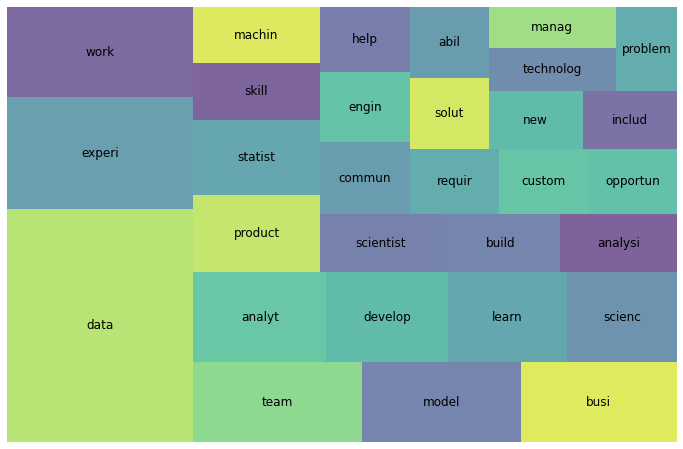

In [18]:
# Look at the top 30 words in a plot:
wc_top30 = wc[wc['rank'] <= 30]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=wc_top30['pct_total'], label=wc_top30['word'], 
              alpha=.70, text_kwargs={'size': 12})
plt.axis('off');

In [19]:
# Add stop words to SpaCy default stop words:
STOP_WORDS = nlp.Defaults.stop_words.union(['data', 'science', 'experience', 
                                            'business', 'work', 'team', 'job', 
                                            'skills', 'product', 'knowledge', 
                                            'description', 'requirements', 
                                            'new', 'scientist'])

# Remove SpaCy default stop words plus my own from the tokens:
tokens = []

# Return lower case tokens and ignore default stop words/punctuation/digits/dates:
for doc in tokenizer.pipe(job['parsed'], batch_size=250):
    
    doc_tokens = []

    for token in doc:
        if (token.text.lower() not in STOP_WORDS) & (token.is_punct == False) & (token.is_space == False):
            
            doc_tokens.append(token.text.lower())
    
    tokens.append(doc_tokens)
            

job['tokens'] = tokens
job['tokens'].head(10)

0    [conceptual, understanding, machine, learning, models, like, naixc2xa8ve, bayes, kmeans, svm, apriori, linearlogistic, regression, neural, random,...
1    [1, help, build, machine, learning, models, pipelines, microservices, help, clients, navigate, healthcare, journeyyou, empowering, improving, gene...
2    [working, consulting, businessyou, responsible, analyzing, large, complex, datasets, identify, meaningful, patterns, lead, actionable, recommendat...
3    [4969, 6756, month, contract, general, supervision, professors, dana, mukamel, kai, zheng, incumbent, join, calmhsa, mental, health, tech, suite, ...
4    [locationusa, xe2x80x93, multiple, locations, 2years, analytics, understand, technical, handle, extraction, preparation, transformation, create, i...
5    [create, intelligence, analytical, reports, visualization, dashboards, bi, tools, like, tableau, power, bi, similar, utilize, scientific, logic, p...
6    [spotify, premium, swells, 96m, subscribers, globe, looking, ways

In [20]:
wc = count(job['tokens'])
print(wc.shape)
wc.head(15)

(12895, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
11,learning,304,882,1.0,0.007576,0.007576,0.713615
324,analytics,245,694,2.0,0.005962,0.013538,0.575117
53,machine,273,675,3.0,0.005798,0.019336,0.640845
269,analysis,291,648,4.0,0.005566,0.024903,0.683099
43,models,242,581,5.0,0.004991,0.029894,0.568075
334,statistical,262,560,6.0,0.004810,0.034704,0.615023
27,ability,240,494,7.0,0.004244,0.038948,0.563380
500,solutions,219,493,8.0,0.004235,0.043182,0.514085
92,help,233,449,9.0,0.003857,0.047039,0.546948
634,insights,202,445,10.0,0.003823,0.050862,0.474178


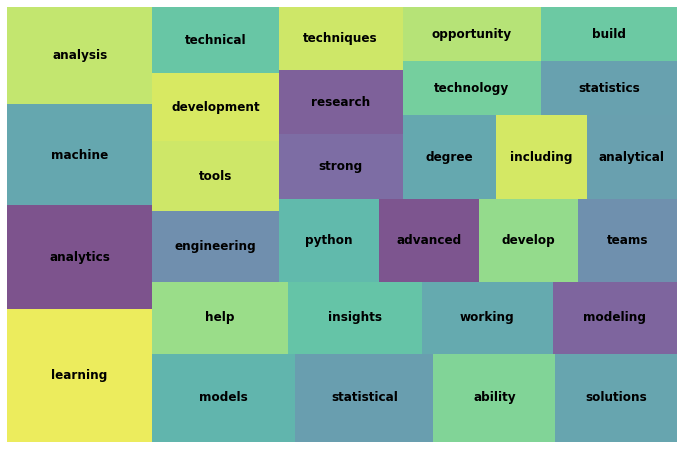

In [21]:
# Look at the top 30 words in a plot:
wc_top30 = wc[wc['rank'] <= 30]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=wc_top30['pct_total'], label=wc_top30['word'], 
              alpha=.70, text_kwargs={'size': 12, 'weight': 'bold'})
plt.axis('off');

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [24]:
# Create the transformer
vect = CountVectorizer(stop_words=STOP_WORDS,  # removes all stop words I specified earlier.
                       min_df=10,  # min documents word needs to be in to be included
                       max_df=0.25,  # can't appear in more than 25% of documnets to remove words that are nonessential.
                       ngram_range=(2, 3)  # min and max of the ngrams (min = bigrams, max = trigrams)
                      )

# Build the vocab
vect.fit(job['parsed'])

# Get sparse Document Term Matrix (DTM)
dtm = vect.transform(job['parsed'])

# Turn into a dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [25]:
dtm.head()

,12 months,35 years,600 cities,600 cities world,ab testing,ab tests,ability build,ability clearly,ability communicate,ability develop,...,worldxe2x80x99s largest,worldxe2x80x99s largest retailer,written communication,written communication ability,written verbal,written verbal communication,xe2x80x9cbig dataxe2x80x9d,years relevant,youll need,youxe2x80x99ll need
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

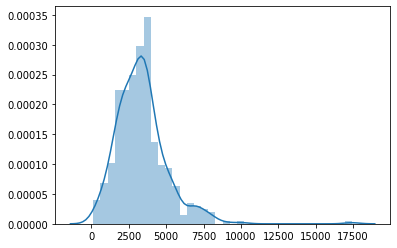

In [26]:
# Get the length of all documents in character count
doc_len = [len(doc) for doc in job['parsed']]

sns.distplot(doc_len);

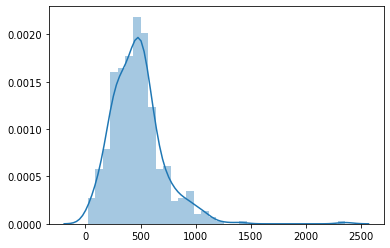

In [27]:
# Get the length of all documents in word count
char_len = [len(doc.split()) for doc in job['parsed']]

sns.distplot(char_len);

In [32]:
wc = count(job['tokens'])
print(wc.shape)
wc.head(15)

(12895, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
11,learning,304,882,1.0,0.007576,0.007576,0.713615
324,analytics,245,694,2.0,0.005962,0.013538,0.575117
53,machine,273,675,3.0,0.005798,0.019336,0.640845
269,analysis,291,648,4.0,0.005566,0.024903,0.683099
43,models,242,581,5.0,0.004991,0.029894,0.568075
334,statistical,262,560,6.0,0.004810,0.034704,0.615023
27,ability,240,494,7.0,0.004244,0.038948,0.563380
500,solutions,219,493,8.0,0.004235,0.043182,0.514085
92,help,233,449,9.0,0.003857,0.047039,0.546948
634,insights,202,445,10.0,0.003823,0.050862,0.474178


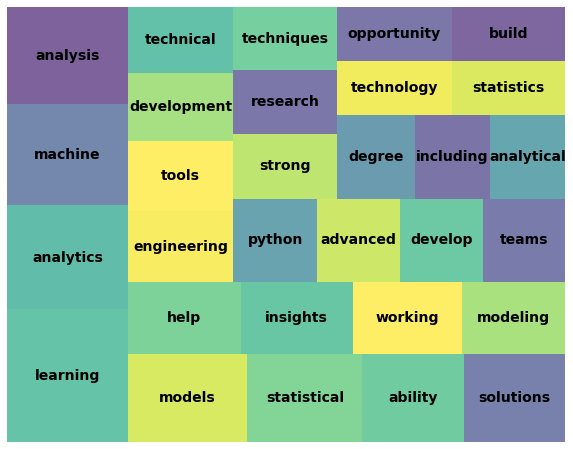

In [33]:
# Look at the top 30 words in a plot:
wc_top30 = wc[wc['rank'] <= 30]

plt.figure(figsize=(10, 8))
squarify.plot(sizes=wc_top30['pct_total'], label=wc_top30['word'], 
              alpha=.70, text_kwargs={'size': 14, 'weight': 'bold'})
plt.axis('off');

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [36]:
# Instantiate the vectorizer object
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=STOP_WORDS,
                        min_df=10,
                        max_df=0.50,
                        ngram_range=(2, 3)
                       )

# Create a vocab and get word counts per document
dtm = tfidf.fit_transform(job['parsed'])

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# look at the Feature Matrix as a DataFrame
dtm.head()

,12 months,35 years,600 cities,600 cities world,ab testing,ab tests,ability build,ability clearly,ability communicate,ability develop,...,worldxe2x80x99s largest,worldxe2x80x99s largest retailer,written communication,written communication ability,written verbal,written verbal communication,xe2x80x9cbig dataxe2x80x9d,years relevant,youll need,youxe2x80x99ll need
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336866,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.206775,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True) and (token.is_space != True)]

In [42]:
# Tunning the Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(2,3),
                        max_df=.5,
                        min_df=10,
                        tokenizer=tokenize)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(job['parsed'])

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,1 year,12 month,2 year,3 year,35 year,3year experience,4 year,5 year,5year experience,600 city,...,year experience,year experience data,year relevant,year relevant work,year work,year work experience,yearsxe2x80x99 experience,youxe2x80x99ll develop,youxe2x80x99ll need,youxe2x80x99ll work
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# Get the Distance Matrix for my tfidf dtm
dist_matrix  = cosine_similarity(dtm)

In [61]:
# Turn my distance matrix into a DataFrame
job_sim = pd.DataFrame(dist_matrix)

In [62]:
# Check my work
print(job_sim.shape)
job_sim.head()

(426, 426)


,0,1,2,3,4,5,6,7,8,9,...,416,417,418,419,420,421,422,423,424,425
0,1.00000,0.098790,0.000000,0.0,0.0,0.101336,0.000000,0.000000,0.035674,0.000000,...,0.037305,0.000000,0.0,0.061901,0.000000,0.007912,0.005856,0.047277,0.012889,0.039986
1,0.09879,1.000000,0.043124,0.0,0.0,0.003908,0.008096,0.061229,0.113948,0.037849,...,0.005378,0.071266,0.0,0.049686,0.027782,0.020460,0.024848,0.060056,0.055629,0.046606
2,0.00000,0.043124,1.000000,0.0,0.0,0.000000,0.000000,0.019437,0.018761,0.031347,...,0.038282,0.016284,0.0,0.050504,0.024676,0.027585,0.011576,0.000000,0.054367,0.019813
3,0.00000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.142950,0.015144,0.026755,...,0.000000,0.000000,0.0,0.106032,0.000000,0.025639,0.000000,0.080891,0.101460,0.145550
4,0.00000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.083199,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [43]:
# Fit NearestNeighbor model on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [44]:
# Get the 5 nearest neighbors for doc 0
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 1.22309091, 1.22309091, 1.25826554, 1.25961593]]),
 array([[  0, 138,  42, 222, 268]], dtype=int64))

In [45]:
# Get the 5 nearest neighbors for doc 218
nn.kneighbors([dtm.iloc[218]])

(array([[0.        , 0.91967638, 1.02339035, 1.07441144, 1.14706042]]),
 array([[218,   3, 370, 148, 366]], dtype=int64))

In [46]:
# Look at the first 250 char text for the doc I am comparing
job['parsed'][218][:250]

'the primary role is to build analytic models in support of a business intelligence team  other responsibilities include understand clarify and analyze customer requirements  communicate accurate and timely project status issues risks and scope change'

In [47]:
# Look at the first 250 char text for the 3rd nearest neighbor
job['parsed'][370][:250]

'internship we are in the business of finding and providing it solutions to our government customersour technology internship program is designed for those with an interest in software development data cyber networking and it supportour program is des'

In [48]:
# Description of the job I would like to have in Data Science
my_job = ['''
Machine learning engineer and visualizations. Work remotely from home full time.
Work anywhere in the country. Endorsement received from Lambda school. 
Entry level position with 1 year or less experience. 
Create visualization based on data to explain data to non-tech persons. 
Create and maintain a database and website with the data.
''']

In [49]:
# Use tf-idf to transform the text of the job I want to run through the knn model
mine = tfidf.transform(my_job)

In [50]:
# Look at the 'mine' object after transform
mine

<1x1275 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [51]:
# Run my job through the knn model to get the 5 closest related jobs
nn.kneighbors(mine.todense())

(array([[1.20640513, 1.20640513, 1.24992363, 1.24992363, 1.30166158]]),
 array([[119, 177, 174, 126,  72]], dtype=int64))

In [54]:
# Look at the most likely result from the knn
job['parsed'][119][:500]

'the data scientist role will be instrumental in helping wwe continue its evolution into a data driven analytics driven organizationthe data scientist will execute analytical tasks such as model development scoring and deliverable production to support wwe decision makersprojectstasks will range from deep dives on specific topics creation of analytical models to building reports and dashboards with kpis and trendsshe will support business stakeholders through handson quantitative analytics of tra'

In [55]:
# Look at the 2nd most likely result from the knn
job['parsed'][177][:500]

'the data scientist role will be instrumental in helping wwe continue its evolution into a data driven analytics driven organizationthe data scientist will execute analytical tasks such as model development scoring and deliverable production to support wwe decision makersprojectstasks will range from deep dives on specific topics creation of analytical models to building reports and dashboards with kpis and trendsshe will support business stakeholders through handson quantitative analytics of tra'

In [56]:
# Look at the 3rd most likely result from the knn
job['parsed'][174][:500]

'job description   data scientist positions offered by ford motor company dearborn mibuild machine learning models to solve business problemsperform data acquisition and cleaning data exploration hypothesis formation and testing experimental design and custom software development     minimum requirements    requires a masterxe2x80x99s or foreign equivalent degree in industrial engineering computer science or a related field  3 years of experience in the position offered or 3 years of experience i'

In [57]:
# Look at the 4th most likely result from the knn
job['parsed'][126][:500]

'job description   data scientist positions offered by ford motor company dearborn mibuild machine learning models to solve business problemsperform data acquisition and cleaning data exploration hypothesis formation and testing experimental design and custom software development     minimum requirements    requires a masterxe2x80x99s or foreign equivalent degree in industrial engineering computer science or a related field  3 years of experience in the position offered or 3 years of experience i'

In [58]:
# Look at the 5th most likely result from the knn
job['parsed'][72][:500]

'responsibilities include supportdevelop models for gap incpricing platform  develop code for measurement of pricing actions  support optimization simulation in pythongurobi environment  enhance optimization models based on measurement opportunities  looking for people with  strong quantitative training  substantial experience in creating optimization models  savviness with pythongurobi framework  business acumen and great communication   qualifications   4years related professional experience  p'

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 